# Controladores
## Integración de Euler en un motor CC
Se tiene un modelo de un motor de corriente continua con un torque de carga en el rotor. Las ecuaciones que lo relacionan dinamicamente son:

$$ i_f' = -\frac{R_F}{L_{FF}} i_f + \frac{1}{L_{FF}} V_f $$

$$ i_a' = -\frac{R_A}{L_{AA}} i_a-\frac{L_{AF}}{L_{AA}} i_f \omega_r + \frac{1}{L_{AA}} V_A $$

$$ \omega_r' = -\frac{B_m}{J} \omega_r+\frac{L_{AF}}{J} i_f i_a-\frac{1}{J} T_L $$

Si la corriente de magnetizacion es constante podemos simplificar la ecuación de la siguiente forma:

$$ K_i = -\frac{L_{AF}}{J} i_f $$

$$ T_m = K_i i_a $$

$$ i_a' = -\frac{R_A}{L_{AA}} i_a-\frac{K_m}{L_{AA}} \omega_r + \frac{1}{L_{AA}} V_A $$

$$ \omega_r' = -\frac{B_m}{J} \omega_r+\frac{K_i}{J} i_a-\frac{1}{J} T_L $$

Determinamos la función de transferencia para $$T_L = 0$$ 

In [8]:
pkg load symbolic
syms Va Ra Laa ia Km w Jm Ki Bm s real
eq2=Jm*s*w==Ki*ia-Bm*w;
eq1=Va==Ra*ia+Laa*s*ia+Km*w;
S1=solve(eq1,eq2,w,Va);
G=factor(S1.w/S1.Va, 's');
pretty(G)

                        Ki                      
  ──────────────────────────────────────────────
                             2                  
  Bm⋅Laa⋅s + Bm⋅Ra + Jm⋅Laa⋅s  + Jm⋅Ra⋅s + Ki⋅Km


La ecuación de transferencia del sistema es:

$$ \frac{\omega_r}{V_a} = \frac{K_i}{s^2 L_{AA} J + s(R_A J + L_{AA}B)+(R_AB+K_iK_m)}$$

Asignamos los valores correspondientes al motor


Transfer function 'sys' from input 'u1' to output ...

                     0.00649               
 y1:  -------------------------------------
      1.83e-12 s^2 + 2.78e-07 s + 4.238e-05

Continuous-time model.
p =

  -1.5176e+05
  -1.5260e+02



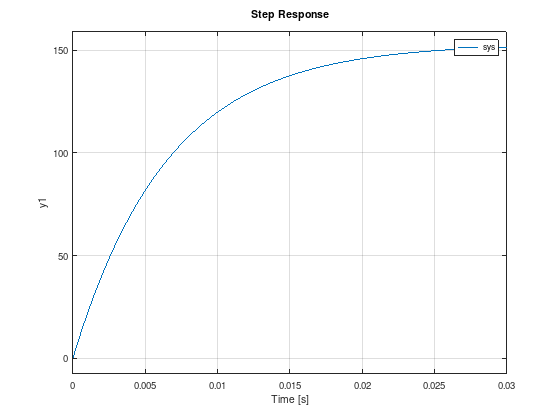

In [11]:
clear all;
pkg load control

Laa=366e-6;
J=5e-9;
Ra=55.6;
B=0;
Ki=6.49e-3;
Km=6.53e-3;

num=[Ki];
den=[Laa*J Ra*J+Laa*B Ra*B+Ki*Km];
sys=tf(num,den)
p = pole(sys)
step(sys)

Si observamos la función de transferencia del motor, podemos observar que los polos son $$ p_1 = -1.51e05 $$ $$ p_2 = -1.52e02 $$. El tiempo al que corresponde el 95% de la dinámica mas rápida es

$$ t_R = \frac{ln(0.95)}{p_1} $$

In [12]:
tR = log(0.95)/p(1)

tR = 3.3799e-07


El tiempo de integración debe ser menor que este mismo, por ejemplo tomamos tres veces menor, es decir 1e-07. Para calcular el tiempo de simulación tomamos la constante mas lenta y calculamos el tiempo para 0.05% de la dinámica más lenta.

$$ t_l = \frac{ln(0.05)}{p_2}$$

In [14]:
tL = log(0.05)/p(2)

tL = 0.019631


Tomamos el triple de este valor, es decir 0.06.

Vamos a simular el desarollo de las variables de estado con respuesta al escalón unitario usando integración de Euler

In [29]:
clear all;
function [X]=modmotor(t_etapa, xant, accion)
 Laa=366e-6; J=5e-9;Ra=55.6;B=0;Ki=6.49e-3;Km=6.53e-3; 
 Va=accion;
 h=1e-7;
 omega= xant(1);
 wp= xant(2);
 for ii=1:t_etapa/h
  wpp =(-wp*(Ra*J+Laa*B)-omega*(Ra*B+Ki*Km)+Va*Ki)/(J*Laa);
  wp=wp+h*wpp;
  omega = omega + h*wp;
 endfor
X=[omega,wp];
end


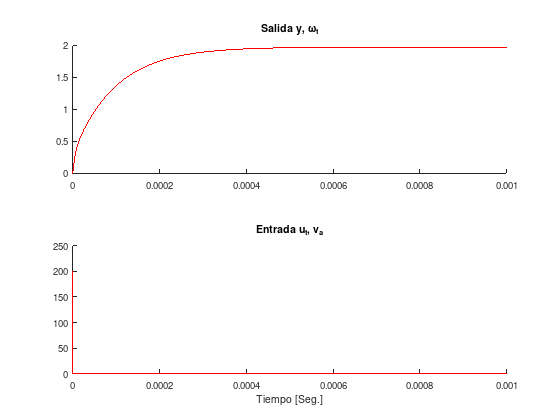

In [31]:
X=-[0; 0];ii=0;t_etapa=1e-7;wRef=2;tF=.001;
%Constantes del PID
Kp=.500;Ki=0.001;Kd=0.00001;color_='r';
% Kp=1;Ki=0;Kd=0.0001;color_='k';
% Kp=10;Ki=0;Kd=0;color_='b';
Ts=t_etapa;
A1=((2*Kp*Ts)+(Ki*(Ts^2))+(2*Kd))/(2*Ts);
B1=(-2*Kp*Ts+Ki*(Ts^2)-4*Kd)/(2*Ts);
C1=Kd/Ts;
e=zeros(tF/t_etapa,1);u=0;
for t=0:t_etapa:tF
  ii=ii+1;k=ii+2;
  X=modmotor(t_etapa, X, u);
  e(k)=wRef-X(1); %ERROR
  u=u+A1*e(k)+B1*e(k-1)+C1*e(k-2); %PID
  x1(ii)=X(1);%Omega
  x2(ii)=X(2);%wp
  acc(ii)=u;
end
t=0:t_etapa:tF;
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(2,1,1);hold on;
plot(t,x1,color_);title('Salida y, \omega_t');
subplot(2,1,2);hold on;
plot(t,acc,color_);title('Entrada u_t, v_a');
xlabel('Tiempo [Seg.]');
% % Para verificar
% Laa=366e-6;
% J=5e-9;
% Ra=55.6;
% B=0;
% Ki=6.49e-3;
% Km=6.53e-3;
% num=[Ki]

## Router TCP/IP
La funcion de transferencia de lazo abierto específica de la pila del router, definido como proceso o planta es

$$ G(s) = \frac{7031250*e^{-0.2s}}{(s+0.667)(s+5)(s+50)} $$

Si reemplazamos el retardo definido por la exponencial con una aproximacion de Padé de primer orden tenemos que

$$ e^{sT} \approx 1-Ts $$

entonces la funcion de transferencia es

$$ G(s) = \frac{7031250*(1+0.2s)}{(s+0.667)(s+5)(s+50)} $$

In [ ]:
g =